In [1]:
import ROOT as rt
from root_numpy import root2array, tree2array
#from root_pandas import read_root
import h5py 

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

from xgboost import XGBClassifier
from xgboost import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve
import keras
import numpy as np
import numpy.lib.recfunctions as nlr
import pandas as pd
import os, sys
from matplotlib import pyplot as plt
import math
from math import pow
from skhep.visual import MplPlotter as skh_plt
try:
    import setGPU
except:
    os.environ['KERAS_BACKEND'] = 'tensorflow'
    os.environ['CUDA_VISIBLE_DEVICES'] = '5'

Welcome to ROOTaaS 6.06/04


Using TensorFlow backend.


setGPU: Setting GPU to: 7


I tensorflow/stream_executor/dso_loader.cc:135] successfully opened CUDA library libcublas.so.8.0 locally
I tensorflow/stream_executor/dso_loader.cc:135] successfully opened CUDA library libcudnn.so.5 locally
I tensorflow/stream_executor/dso_loader.cc:135] successfully opened CUDA library libcufft.so.8.0 locally
I tensorflow/stream_executor/dso_loader.cc:135] successfully opened CUDA library libcuda.so.1 locally
I tensorflow/stream_executor/dso_loader.cc:135] successfully opened CUDA library libcurand.so.8.0 locally


In [15]:
variables = ['Higgs_pt','Higgs_eta','dRmm','dEtamm','dPhimm','M_jj','pt_jj','eta_jj','phi_jj','dPhijj','leadingJet_pt','subleadingJet_pt',
                                   'leadingJet_eta','subleadingJet_eta','M_mmjj','pt_mmjj','eta_mmjj','phi_mmjj','dEta_jj','Zep','dRmin_mj', 'dRmax_mj'
                                   ,'dRmin_mmj','dRmax_mmj','leadingJet_qgl','subleadingJet_qgl','cthetaCS',]#,'Higgs_mass' ]
mass_var=['Higgs_mass']
id_variables = ['run','lumi','event']
wt_variables = ['genWeight']

In [16]:
def convert(tree, target=0):
    feature = tree2array(tree,
                        branches = variables+mass_var+id_variables+wt_variables ,
                        #branches = variables,
                         selection = 'cat_index==7')
    if target == 0:
        label = np.zeros(shape = feature.shape, dtype=[('label','f4')])
    else:
        label = np.ones(shape = feature.shape, dtype=[('label','f4')])
    #data = nlr.merge_arrays([label,feature], flatten=True)
    #auxInfo = tree2array(tree,
    #                     branches = ['mass_jj','mass_gg'])
    return feature

In [17]:
from keras import optimizers
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

In [18]:
SIGNAL_FILE='/bigdata/shared/idutta/VBFHToMuMu.root'
BKG_FILE='/bigdata/shared/idutta/DYJetsToLL.root'
#BKG_FILE = '/bigdata/shared/idutta/DYJets.root'
BKG_FILE0='/bigdata/shared/idutta/DY0J.root'
BKG_FILE1='/bigdata/shared/idutta/DY1J.root'
BKG_FILE2='/bigdata/shared/idutta/DY2J.root'
BKG_FILE_2018='/bigdata/shared/idutta/DYJetsToLL_VBFfilter.root'
sigfile = rt.TFile.Open(SIGNAL_FILE)
bkgfile = rt.TFile.Open(BKG_FILE)
bkgfile0 = rt.TFile.Open(BKG_FILE0)
bkgfile1 = rt.TFile.Open(BKG_FILE1)
bkgfile2 = rt.TFile.Open(BKG_FILE2)
bkgfile_2018 = rt.TFile.Open(BKG_FILE_2018)
sigtree = sigfile.Get("cattree")
bkgtree = bkgfile.Get("cattree")
bkgtree0 = bkgfile0.Get("cattree")
bkgtree1 = bkgfile1.Get("cattree")
bkgtree2 = bkgfile2.Get("cattree")
bkgtree3 = bkgfile_2018.Get("cattree")
signp = convert(sigtree, 1)
bkgnp = convert(bkgtree, 0)
bkgnp0 = convert(bkgtree0, 0)
bkgnp1 = convert(bkgtree1, 0)
bkgnp2 = convert(bkgtree2, 0)
bkgnp3 = convert(bkgtree3, 0)
#get evt weights for signal and background
#sig_evtWt_np = tree2array(sigtree,branches ='genWeight',selection = 'cat_index==7')
#bkg_evtWt_np = tree2array(bkgtree,branches ='genWeight',selection = 'cat_index==7')

sig_frame = pd.DataFrame.from_records(signp)
bkg_frame= pd.DataFrame.from_records(bkgnp)
bkg_frame0= pd.DataFrame.from_records(bkgnp0)
bkg_frame1= pd.DataFrame.from_records(bkgnp1)
bkg_frame2= pd.DataFrame.from_records(bkgnp2)
bkg_frame3= pd.DataFrame.from_records(bkgnp3)
#sig_evtWt_pd = pd.DataFrame.from_records(sig_evtWt_np)
#bkg_evtWt_pd = pd.DataFrame.from_records(bkg_evtWt_np)
#print sig_frame, bkg_frame
var_indices = [sig_frame.columns.get_loc(v) for v in variables] # get positions of all the variables set above
mass_indices = [sig_frame.columns.get_loc(v) for v in mass_var]
id_var_indices = [sig_frame.columns.get_loc(v) for v in id_variables]
wt_var_indices = [sig_frame.columns.get_loc(v) for v in wt_variables]


# Standardize only the actual variables not event ID or genweights
x_mean_sig = (sig_frame.loc[:,variables]).mean()
x_std_sig = (sig_frame.loc[:,variables]).std()
x_mean_bkg = (bkg_frame.loc[:,variables]).mean()
x_std_bkg = (bkg_frame.loc[:,variables]).std()
x_mean_bkg0 = (bkg_frame0.loc[:,variables]).mean()
x_std_bkg0 = (bkg_frame0.loc[:,variables]).std()
x_mean_bkg1 = (bkg_frame1.loc[:,variables]).mean()
x_std_bkg1 = (bkg_frame1.loc[:,variables]).std()
x_mean_bkg2 = (bkg_frame2.loc[:,variables]).mean()
x_std_bkg2 = (bkg_frame2.loc[:,variables]).std()
x_mean_bkg3 = (bkg_frame3.loc[:,variables]).mean()
x_std_bkg3 = (bkg_frame3.loc[:,variables]).std()

sig_frame.loc[:,variables] = (sig_frame.loc[:,variables]-x_mean_sig)/x_std_sig    
bkg_frame.loc[:,variables] = (bkg_frame.loc[:,variables]-x_mean_bkg)/x_std_bkg
bkg_frame0.loc[:,variables] = (bkg_frame0.loc[:,variables]-x_mean_bkg0)/x_std_bkg0
bkg_frame1.loc[:,variables] = (bkg_frame1.loc[:,variables]-x_mean_bkg1)/x_std_bkg1
bkg_frame2.loc[:,variables] = (bkg_frame2.loc[:,variables]-x_mean_bkg2)/x_std_bkg2
bkg_frame3.loc[:,variables] = (bkg_frame3.loc[:,variables]-x_mean_bkg3)/x_std_bkg3


signal = sig_frame.values
background = bkg_frame.values
background0 = bkg_frame0.values
background1 = bkg_frame1.values
background2 = bkg_frame2.values
background3 = bkg_frame3.values

frames = [bkg_frame,bkg_frame0,bkg_frame1,bkg_frame2]

background_full_frame = pd.concat(frames)
background_full = background_full_frame.values
#print "After standardizing"
print "length of Signal :",len(sig_frame.values)
print "length of background :",len(bkg_frame.values)
print "length of background DY 0J:",len(bkg_frame0.values)
print "length of background DY 1J:",len(bkg_frame1.values)
print "length of background DY 2J:",len(bkg_frame2.values)
print "length of background DY Jet binned + inclusive:",len(background_full_frame.values)
print "length of background DY Jet VBF filter 2018:",len(bkg_frame3.values)






signal_wt = signal[:,wt_var_indices]
bkg_wt = background[:,wt_var_indices]
bkg_wt0 = background0[:,wt_var_indices]
bkg_wt1 = background1[:,wt_var_indices]
bkg_wt2 = background2[:,wt_var_indices]
bkg_wt_full = background_full[:,wt_var_indices]
bkg3_wt = background3[:,wt_var_indices]

print "sum of weights for signal before scaling: " 
print np.sum(signal_wt)

sig_scale= np.sum(bkg3_wt)/np.sum(signal_wt)
signal[:,wt_var_indices] = np.multiply(signal_wt, sig_scale)
signal_wt = signal[:,wt_var_indices]


print "sum of weights for signal after scaling: " 
print np.sum(signal_wt)
#print "sum of weights for bkg after scaling: " 
#print np.sum(bkg_wt_full)

#print "sum of weights for DY 0J after scaling: " 
#print np.sum(bkg_wt0)
#print "sum of weights for DY 1J after scaling: " 
#print np.sum(bkg_wt1)
#print "sum of weights for DY 2J after scaling: " 
#print np.sum(bkg_wt2)

#print "sum of weights for DY inclusive after scaling: " 
#print np.sum(bkg_wt)


print "sum of weights for DY VBF filter: " 
print np.sum(bkg3_wt)

# Shuffle before splitting into train-val
randix = np.arange(len(background))
np.random.shuffle(randix)
#np.random.shuffle(background)
#np.random.shuffle(signal)

randix4 = np.arange(len(background_full))
np.random.shuffle(randix4)

randix2 = np.arange(len(signal))
np.random.shuffle(randix2)
signal_ = signal[randix2]
background_ = background[randix]
background_full_ = background_full[randix4]


randix5 = np.arange(len(background3))
np.random.shuffle(randix5)
background_VBFfilter_ = background3[randix5]


#signal_test_ =signal_[0:103885]
#signal_train_ =signal_[103885:207770]

#Using 2017 DY samples for test and 2018 DY VBF filter for train
#sig_test_label = np.ones(len(signal_test_))
#sig_train_label = np.ones(len(signal_train_))
sig_label = np.ones(len(signal_))
bkg_label = np.zeros(len(background_))
#bkg_full_label = np.zeros(len(background_full_))
bkg_VBF_label = np.zeros(len(background_VBFfilter_))


#data_test = np.concatenate((signal_test_,background_))
#label_test = np.concatenate((sig_test_label,bkg_label))

#data_train = np.concatenate((signal_train_,background_VBFfilter_))
data_train = np.concatenate((signal_,background_VBFfilter_))
label_train = np.concatenate((sig_label,bkg_VBF_label))



randix3 = np.arange(len(data_train))
np.random.shuffle(randix3)
data_train= data_train[randix3,...]
label_train = label_train[randix3,...]

#randix6 = np.arange(len(data_test))
#np.random.shuffle(randix6)
#data_test= data_test[randix6,...]
#label_test = label_test[randix6,...]

print data_train.shape
print label_train.shape




length of Signal : 207770
length of background : 14836
length of background DY 0J: 255
length of background DY 1J: 3995
length of background DY 2J: 24111
length of background DY Jet binned + inclusive: 43197
length of background DY Jet VBF filter 2018: 507840
sum of weights for signal before scaling: 
7.35866642673
sum of weights for signal after scaling: 
6258.22341124
sum of weights for DY VBF filter: 
6258.22341124
(715610, 32)
(715610,)


In [6]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation,Dropout, Input, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [7]:
def make_cls_model(inp_shape, b_norm = False, n_hidden = 1, hidden= 100, do = 0.2):
    i = Input(inp_shape, name='features')
    di = i
    for h in range(n_hidden):
        d = Dense(hidden, name='hidden_%d'%h, activation='tanh')(di)
        if do:
            d = Dropout(do)(d)
        if b_norm:
            d = BatchNormalization()(d)
        di = d
    o = Dense(1, name='categorization', activation='sigmoid')(d)
    model = Model(i,o,name='classifier')
    #model.summary()
    return model

In [8]:
def fit_cls_model(model,x_train_reduced,y_train, x_train_wt,batch_size = 20, val_split=0.2):
    hist = model.fit(x_train_reduced, y_train, sample_weight= x_train_wt,batch_size=batch_size, nb_epoch=500,verbose=0,validation_split=val_split,
                  callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')])
    return hist

In [9]:
def show_losses( histories ):
    plt.figure(figsize=(10,10))
    #plt.ylim(bottom=0)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Error by Epoch')
    colors=[]
    do_acc=False
    for label,loss in histories:
        color = tuple(np.random.random(3))
        colors.append(color)
        l = label
        vl= label+" validation"
        if 'acc' in loss.history:
            l+=' (acc %2.4f)'% (loss.history['acc'][-1])
            do_acc = True
        if 'val_acc' in loss.history:
            vl+=' (val acc %2.4f)'% (loss.history['val_acc'][-1])
            do_acc = True
        plt.plot(loss.history['loss'], label=l, color=color)
        if 'val_loss' in loss.history:
            plt.plot(loss.history['val_loss'], lw=2, ls='dashed', label=vl, color=color)


    plt.legend()
    #plt.yscale('log')
    plt.show()
    if not do_acc: return
    plt.figure(figsize=(10,10))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    for i,(label,loss) in enumerate(histories):
        color = colors[i]
        if 'acc' in loss.history:
            plt.plot(loss.history['acc'], lw=2, label=label+" accuracy", color=color)
        if 'val_acc' in loss.history:
            plt.plot(loss.history['val_acc'], lw=2, ls='dashed', label=label+" validation accuracy", color=color)
    plt.legend(loc='lower right')
    plt.show()

(214683,)
[[ 0.00298475]
 [ 0.00294732]
 [ 0.09358574]
 ..., 
 [ 0.00297696]
 [-0.09158072]
 [ 0.00297687]]
(500927, 27) (214683, 27)
(500927,) (214683,)
145369.0 62401.0
(500927,)


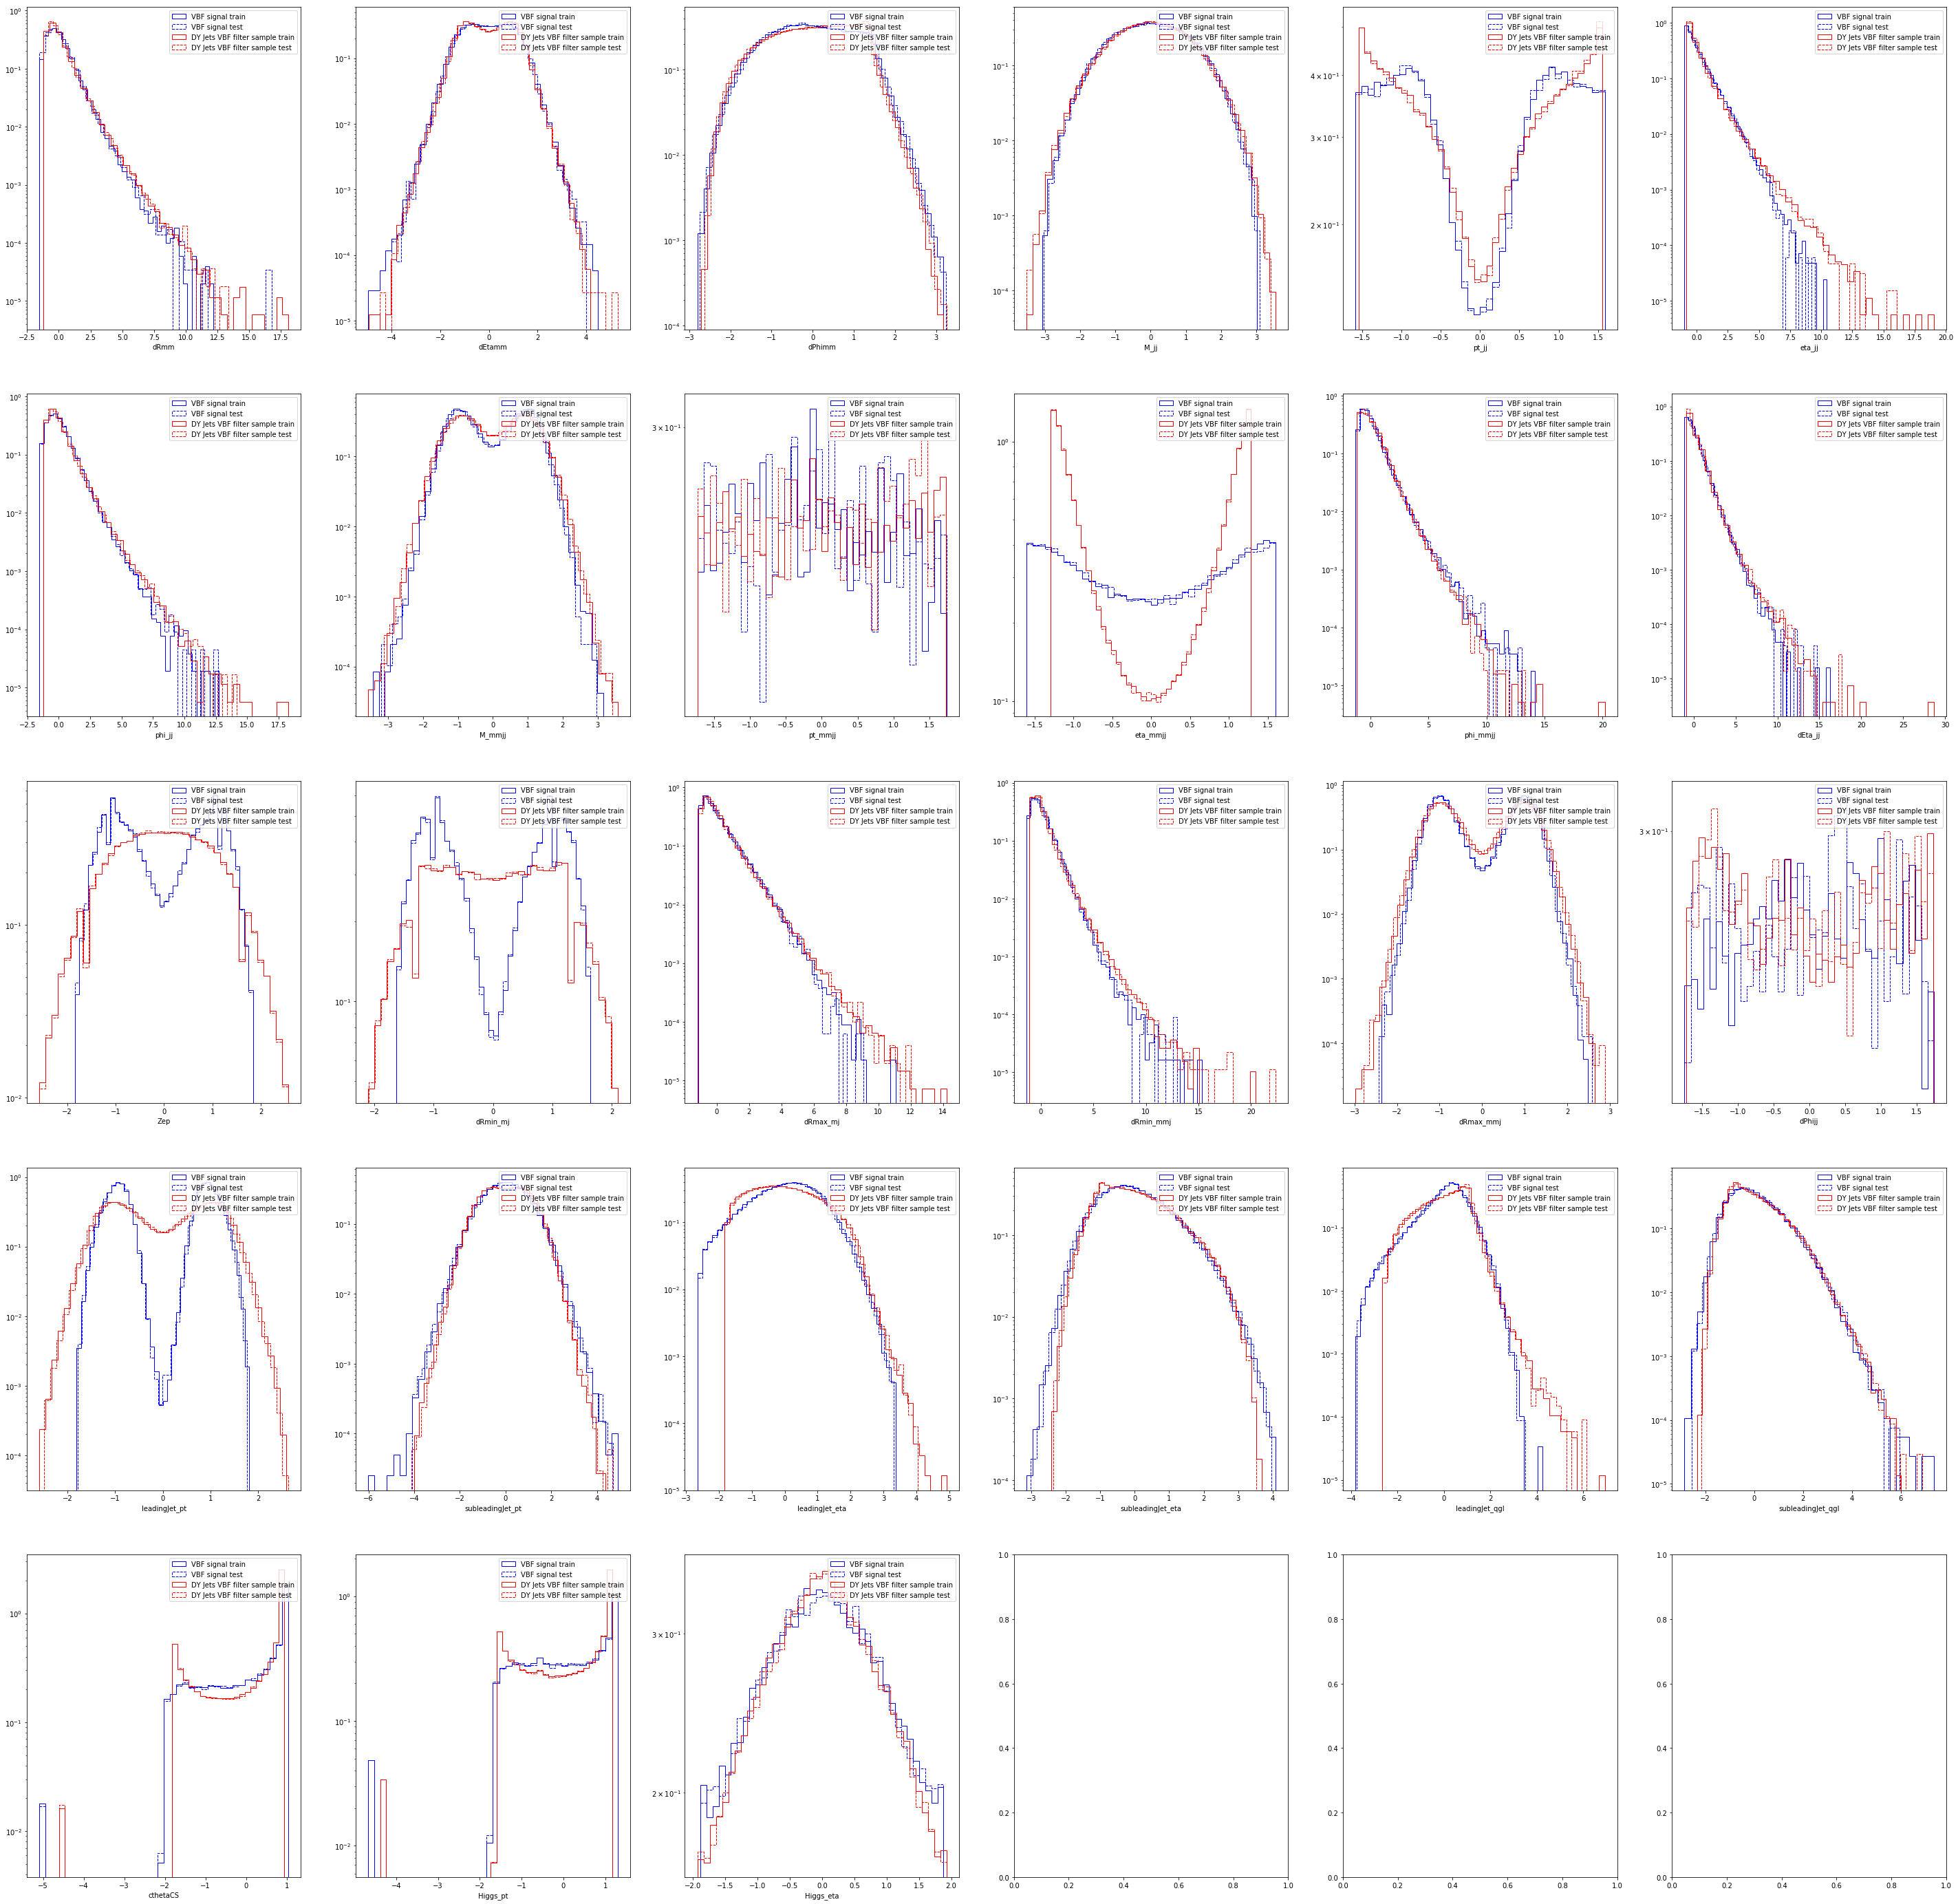

In [19]:
seed = 7
test_size = 0.3
x_train, x_test, y_train, y_test = train_test_split(data_train, label_train, test_size=test_size, random_state=seed)
print y_test.shape
is_sig_test = y_test==1
is_bkg_test = np.invert(is_sig_test)

# For training we ignore the columns with the event ID information
x_train_reduced = x_train[:,var_indices]
x_test_reduced = x_test[:,var_indices]
z_train=x_train[:,mass_indices]
z_test = x_test[:,mass_indices]
   
x_test_index = x_test[:,id_var_indices]
x_train_index = x_train[:,id_var_indices]

x_train_wt = x_train[:,wt_var_indices]
x_test_wt = x_test[:,wt_var_indices]
print x_train_wt
print x_train_reduced.shape, x_test_reduced.shape
print y_train.shape, y_test.shape
print y_train.sum(), y_test.sum()
print x_train_reduced[:,0].shape
HLF = ['dRmm','dEtamm','dPhimm','M_jj','pt_jj','eta_jj','phi_jj','M_mmjj','pt_mmjj','eta_mmjj','phi_mmjj','dEta_jj','Zep','dRmin_mj', 'dRmax_mj'
                                   ,'dRmin_mmj','dRmax_mmj','dPhijj','leadingJet_pt','subleadingJet_pt',
                                   'leadingJet_eta','subleadingJet_eta','leadingJet_qgl','subleadingJet_qgl','cthetaCS','Higgs_pt','Higgs_eta']

f, ax_arr = plt.subplots(5, 6, figsize=(50,50))
i=0
    
for j in range(0,5):
    for k in range(0,6):
        x_train_sig = []
        x_train_bkg =[]
        x_test_sig = []
        x_test_bkg = []
        temp = x_train_reduced[:,i]
        test_tmp = x_test_reduced[:,i]
        for m in range (0,len(y_train)):
            if(y_train[m]==1): x_train_sig.append(temp[m])
            else: x_train_bkg.append(temp[m])
        for m in range (0,len(y_test)): 
            if(y_test[m]==1): x_test_sig.append(test_tmp[m])
            else: x_test_bkg.append(test_tmp[m])    
        ax_arr[j,k].hist(x_train_sig, bins=40, normed=True, histtype='step', label='VBF signal train',color='b')
        ax_arr[j,k].hist(x_test_sig, bins=40, normed=True, histtype='step', linestyle =('dashed'), label='VBF signal test', color = 'b')
        ax_arr[j,k].hist(x_train_bkg, bins=40, normed=True, histtype='step', label='DY Jets VBF filter sample train',color='r')
        ax_arr[j,k].hist(x_test_bkg, bins=40, normed=True, histtype='step', linestyle =('dashed'),label='DY Jets VBF filter sample test', color = 'r')
        ax_arr[j,k].set_xlabel(HLF[i])
        ax_arr[j,k].legend(prop={'size': 10})
        ax_arr[j,k].legend(loc='best')
        ax_arr[j,k].set_yscale("log")
        i+=1
        if i == 27: break
    if i ==27 : break
plt.show()  


In [20]:
def train_model(varlist):

    hists = []

    x_train_reduced_smaller = x_train_reduced[:, varlist]
    x_test_reduced_smaller = x_test_reduced[:, varlist]

    m_best = make_cls_model((x_train_reduced_smaller.shape[1],), True, 3, 100, 0.2)
    m_best.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    h = fit_cls_model(m_best, x_train_reduced_smaller,y_train, x_train_wt.ravel(),10000)
    
    y_pred = m_best.predict(x_test_reduced_smaller, batch_size=10000).ravel()
    
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
    auc_keras = auc(fpr_keras, tpr_keras)

#     y_pred_bkg = y_pred[y_test==0]
#     y_pred_sig = y_pred[y_test==1]
#     plt.hist(y_pred_sig,bins=np.linspace(0,1,100), density=1.0, lw=2.0, histtype="step",label ='signal')
#     plt.hist(y_pred_bkg,bins=np.linspace(0,1,100), density=1.0, lw=2.0, histtype="step",label='bkg')
#     plt.legend()
#     plt.show()
    
#     fpr_keras_tmp, tpr_keras_tmp, thresholds_keras_tmp = roc_curve(y_test,y_pred)
#     auc_keras = auc(fpr_keras, tpr_keras)
    
#     plt.plot(fpr_keras_tmp, tpr_keras_tmp, label='Keras Test (area = {:.3f})'.format(auc_keras))
#     #plt.xlim(0,0.02)
#     #plt.ylim(0.8,1.0)
#     plt.xlabel("False positive rate")
#     plt.ylabel('True positive rate')
#     plt.title('ROC curve')
#     plt.legend(loc='best')
#     plt.show()  

    return fpr_keras, tpr_keras
    #hists.append(h)
    #show_losses( [("VBF entropy", h)] )

In [21]:
rocs = []

for nvars in [1,2,5,10,15,20,21,22,23,24,25,26,27]:
    print nvars
    rocs += [train_model(range(nvars))]

1
Epoch 00024: early stopping
2
Epoch 00028: early stopping
5
Epoch 00090: early stopping
10
Epoch 00086: early stopping
15
Epoch 00075: early stopping
20
Epoch 00040: early stopping
21
Epoch 00041: early stopping
22
Epoch 00044: early stopping
23
Epoch 00051: early stopping
24
Epoch 00043: early stopping
25
Epoch 00057: early stopping
26
Epoch 00047: early stopping
27
Epoch 00050: early stopping


Text(0,0.5,'tpr')

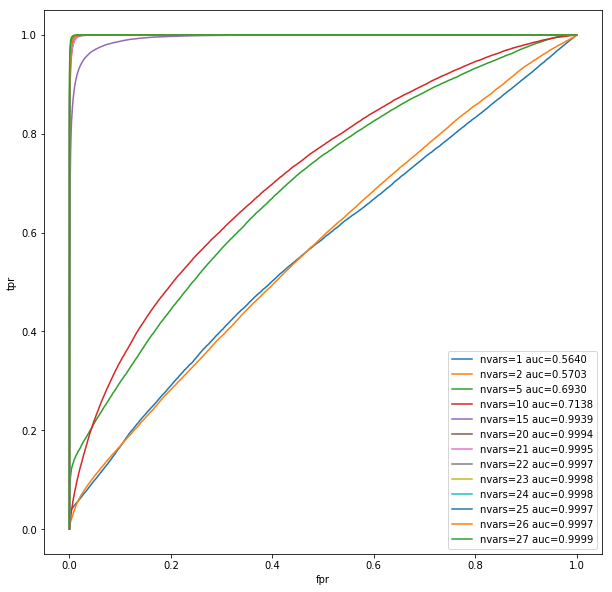

In [22]:
nvars = [1,2,5,10,15,20,21,22,23,24,25,26,27]
plt.figure(figsize=(10, 10))
for (fpr, tpr), nvar in zip(rocs, nvars):
    auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, label="nvars={0} auc={1:.4f}".format(nvar, auc_val))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")

Text(0,0.5,'tpr')

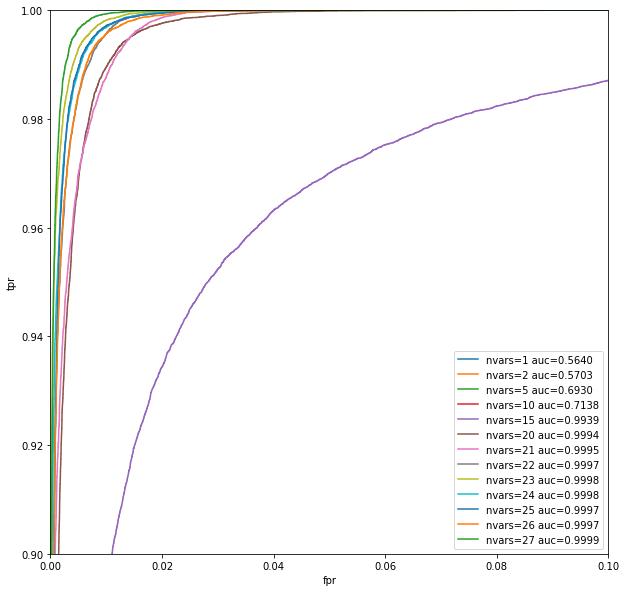

In [23]:
nvars = [1,2,5,10,15,20,21,22,23,24,25,26,27]
plt.figure(figsize=(10, 10))
for (fpr, tpr), nvar in zip(rocs, nvars):
    auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, label="nvars={0} auc={1:.4f}".format(nvar, auc_val))
    plt.xlim(0,0.1)
    plt.ylim(0.9,1)
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")

In [28]:
def train_model_new(varlist):

    
    #print varlist
    x_train_reduced_smaller = x_train_reduced[:, varlist]
    x_test_reduced_smaller = x_test_reduced[:, varlist]

    m_best = make_cls_model((x_train_reduced_smaller.shape[1],), True, 3, 100, 0.2)
    m_best.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    h = fit_cls_model(m_best, x_train_reduced_smaller,y_train, x_train_wt.ravel(),10000)

    y_pred = m_best.predict(x_test_reduced_smaller, batch_size=10000).ravel()

    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
    auc_keras = auc(fpr_keras, tpr_keras)

#     y_pred_bkg = y_pred[y_test==0]
#     y_pred_sig = y_pred[y_test==1]
#     plt.hist(y_pred_sig,bins=np.linspace(0,1,100), density=1.0, lw=2.0, histtype="step",label ='signal')
#     plt.hist(y_pred_bkg,bins=np.linspace(0,1,100), density=1.0, lw=2.0, histtype="step",label='bkg')
#     plt.legend()
#     plt.show()

#     fpr_keras_tmp, tpr_keras_tmp, thresholds_keras_tmp = roc_curve(y_test,y_pred)
#     auc_keras = auc(fpr_keras, tpr_keras)

#     plt.plot(fpr_keras_tmp, tpr_keras_tmp, label='Keras Test (area = {:.3f})'.format(auc_keras))
#     #plt.xlim(0,0.02)
#     #plt.ylim(0.8,1.0)
#     plt.xlabel("False positive rate")
#     plt.ylabel('True positive rate')
#     plt.title('ROC curve')
#     plt.legend(loc='best')
#     plt.show()  

    return fpr_keras, tpr_keras

In [29]:
rocs_new=[]
for k in range(0,27):
    varlist = [i for i in range(0,27) if i != k]
    rocs_new += [train_model_new(varlist)]

Epoch 00049: early stopping
Epoch 00076: early stopping
Epoch 00054: early stopping
Epoch 00066: early stopping
Epoch 00044: early stopping
Epoch 00052: early stopping
Epoch 00049: early stopping
Epoch 00049: early stopping
Epoch 00066: early stopping
Epoch 00045: early stopping
Epoch 00049: early stopping
Epoch 00046: early stopping
Epoch 00064: early stopping
Epoch 00056: early stopping
Epoch 00055: early stopping
Epoch 00061: early stopping
Epoch 00047: early stopping
Epoch 00041: early stopping
Epoch 00035: early stopping
Epoch 00086: early stopping
Epoch 00062: early stopping
Epoch 00049: early stopping
Epoch 00045: early stopping
Epoch 00049: early stopping
Epoch 00048: early stopping
Epoch 00073: early stopping
Epoch 00047: early stopping


Text(0,0.5,'tpr')

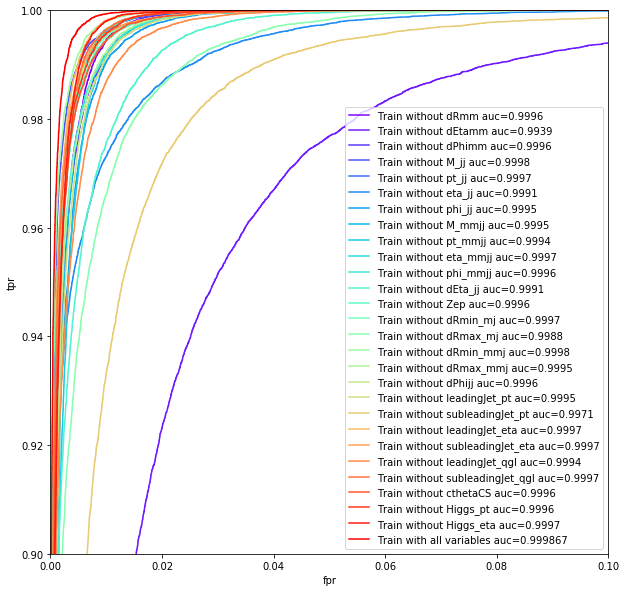

In [38]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, 28))
plt.figure(figsize=(10, 10))
for (fpr, tpr), hlf,c  in zip(rocs_new, HLF,colors):
    auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, label="Train without {0} auc={1:.4f}".format(hlf, auc_val),color = c)
    plt.xlim(0,0.1)
    plt.ylim(0.9,1)
fpr_full,tpr_full = rocs[12]
auc_val = auc(fpr_full, tpr_full)
plt.plot(fpr_full, tpr_full, label="Train with all variables auc={0:4f}".format( auc_val), color = colors[27])
plt.xlim(0,0.1)
plt.ylim(0.9,1)
plt.legend(loc='best')
plt.xlabel("fpr")
plt.ylabel("tpr")